# MAXCUT Landscape Analysis

### Initial Setup
In this notebook, we start by importing necessary libraries. We use `numpy` for numerical operations, `matplotlib.pyplot` for plotting, and various components from `qiskit` to build and simulate quantum circuits. The `QAOA` from `qiskit.algorithms` is specifically used for implementing the Quantum Approximate Optimization Algorithm.


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.algorithms.optimizers import COBYLA, ADAM
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut
from qiskit.opflow import AerPauliExpectation, PauliSumOp
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter


# Set a global style
plt.style.use('ggplot')

### Defining the Adjacency Matrix
The Max-Cut problem is represented using an adjacency matrix \$A\$. This matrix represents the graph where each element \$A_{ij}\$ is 1 if there is an edge between nodes \$i\$ and \$j\$, and 0 otherwise. Our sample graph has 5 nodes.


In [2]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1],
    [1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [1, 0, 0, 1, 0]
])
print(adjacency_matrix)


[[0 1 1 0 1]
 [1 0 1 0 0]
 [1 1 0 1 0]
 [0 0 1 0 1]
 [1 0 0 1 0]]


### Visualizing the Graph
To better understand the structure of the graph we are working with, let's visualize it. Each node represents a qubit, and each edge represents a connection (problem constraint) between the qubits.
`

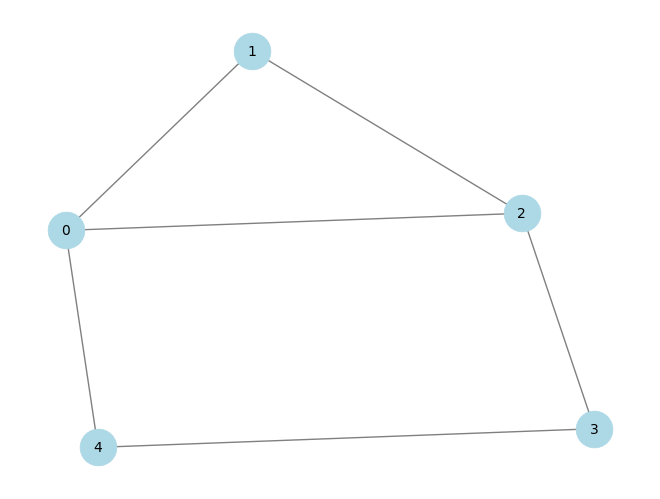

In [3]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_matrix(adjacency_matrix)

# Draw the graph
pos = nx.spring_layout(G)  # Define a layout for consistent node positioning
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.show()

# Regular Graphs (k-regular $k \in \{3,4 \}$)

Many papers focus largely on 3-regular or 4-regular graphs. Infact in  ["Training the Quantum Approximate Optimization Algorithm without access to a Quantum Processing Unit"](https://ar5iv.labs.arxiv.org/html/1908.08862)

They make the claim, "We might therefore find the average optimal parameters once and reuse them for all instances, thereby eliminating the computational cost per instance of finding the optimal parameters. In addition to that one can find the optimal parameters without any call to the QPU leveraging the experimental finding that the optimal parameters do not depend on the problem size."


So lets build the landscape for a problem that is $k$-regular

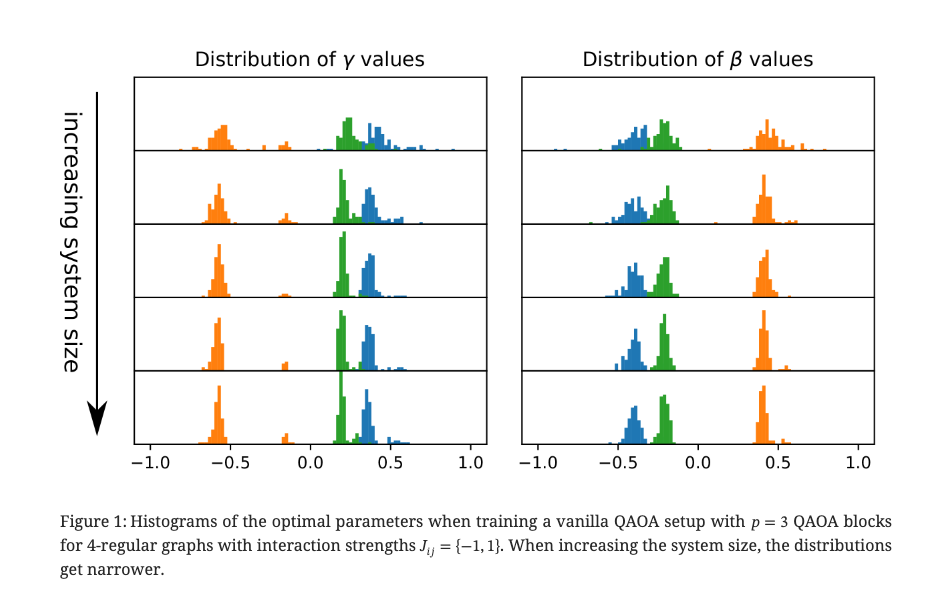

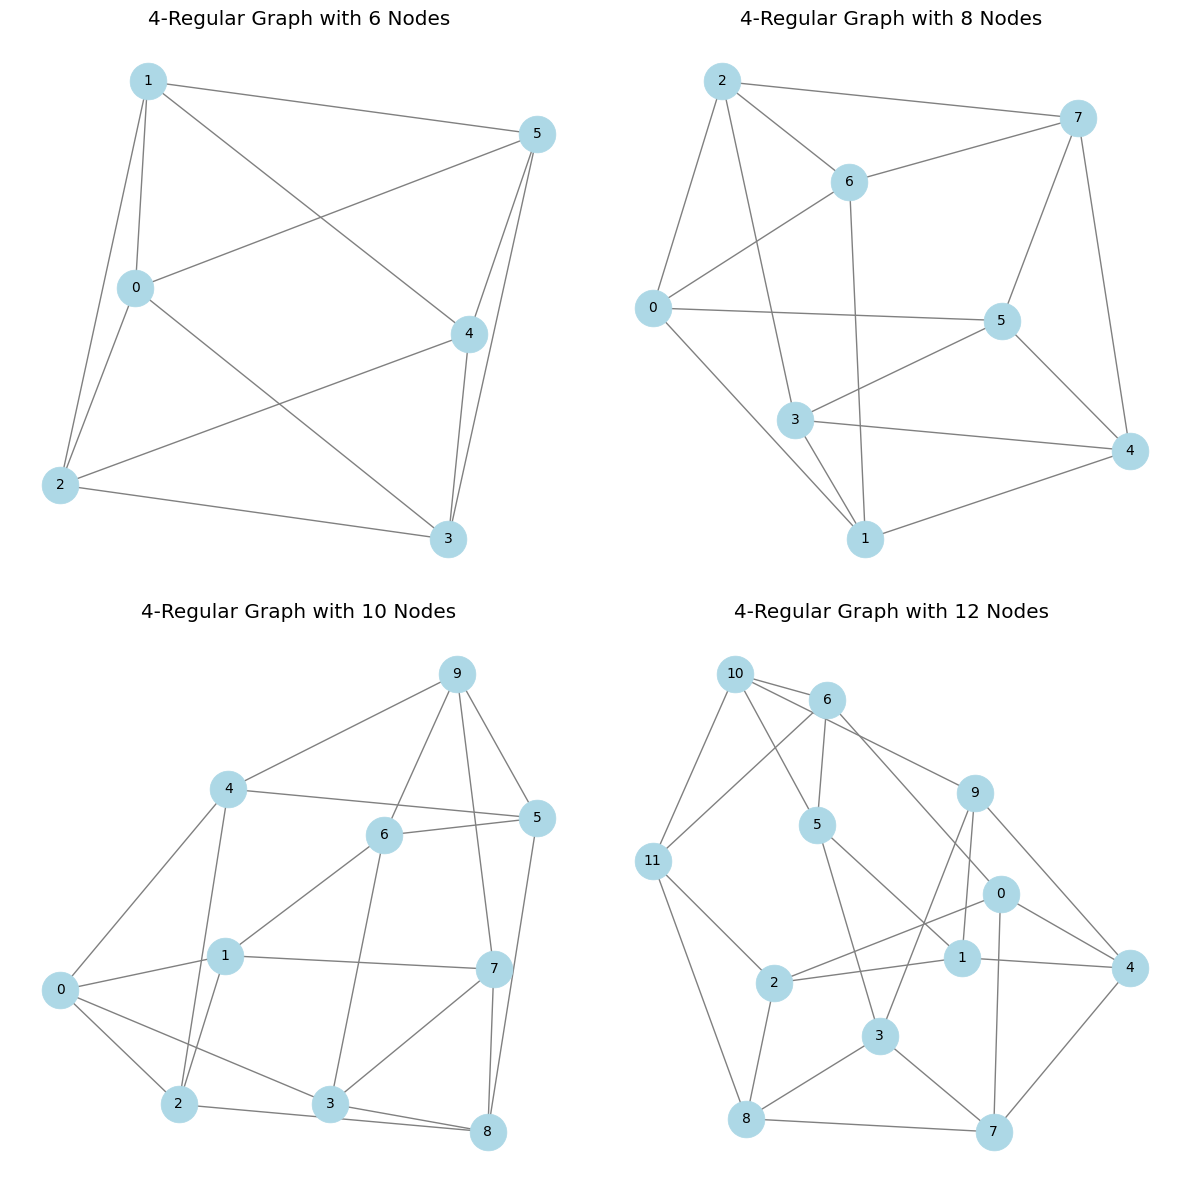

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Node sizes to generate 4-regular graphs for
node_sizes = [6, 8, 10, 12, 14]

# Setting up the plot for a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Counter for the subplot index
counter = 0
for size in node_sizes:
    if counter >= 4:  # Only plot the first four graphs
        break
    ax = axes[counter // 2, counter % 2]
    G = nx.random_regular_graph(4, size)
#    pos = nx.spring_layout(G)  # Define a layout for consistent node positioning
    nx.draw(G, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
    ax.set_title(f"4-Regular Graph with {size} Nodes")
    counter += 1

plt.tight_layout()
plt.show()


### Setting up the Max-Cut Problem
Using Qiskit's `Maxcut` class, we convert our graph represented by the adjacency matrix into a problem that can be solved using a quantum algorithm. The `to_ising` method translates this problem into the Ising model, a formulation suitable for quantum optimization algorithms. In the Ising model, the goal is to minimize the Hamiltonian \$H = -\sum_{ij} A_{ij} Z_i Z_j\$, where \$Z_i\$ and \$Z_j\$ are the Pauli-Z operators on qubits \$i\$ and \$j\$.

Lets use a 6 node 4-regular graph

In [31]:
G = nx.random_regular_graph(3, 4)
# Generate the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G)
max_cut = Maxcut(adjacency_matrix)
qubitOp, offset = max_cut.to_quadratic_program().to_ising()

/var/folders/pv/xwqtt1w56s7dkzm8bn7k9gx00000gn/T/ipykernel_67710/2781843548.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


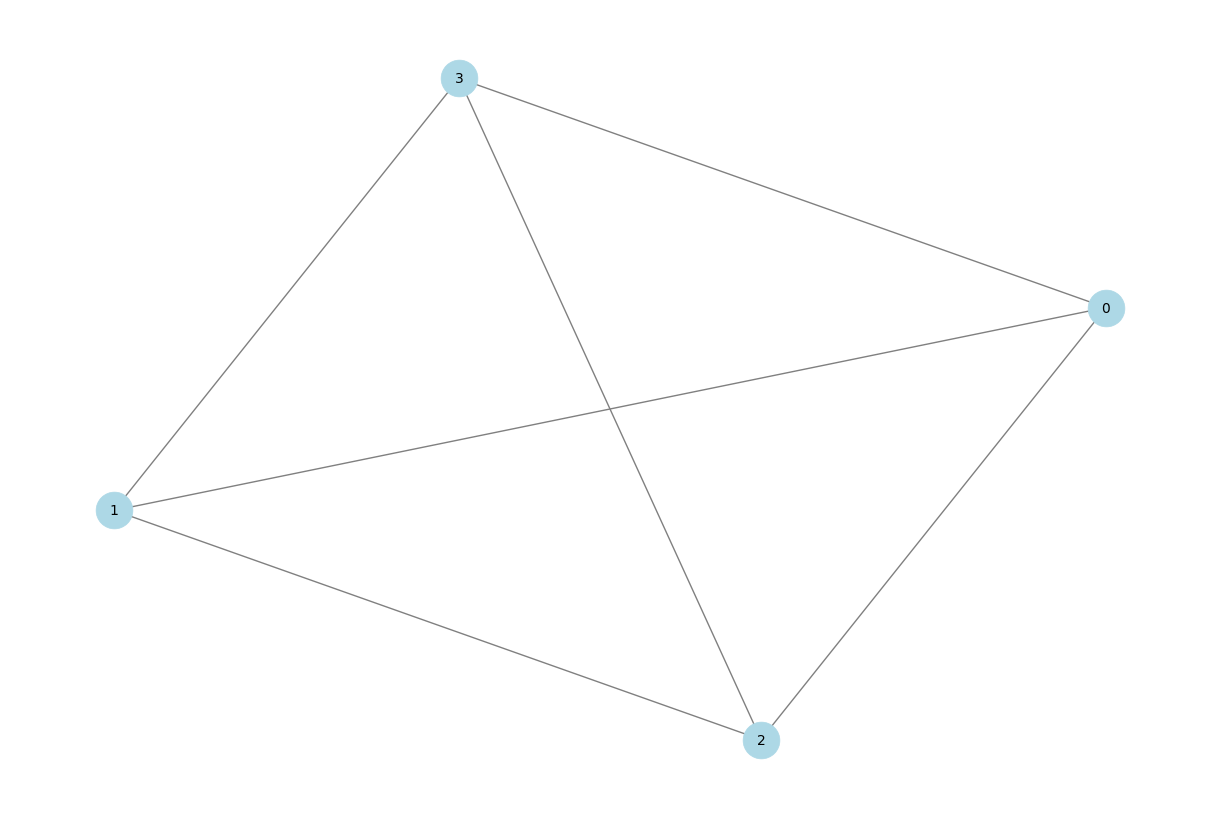

In [32]:
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.show()

### QAOA Circuit Preparation
We initialize the QAOA circuit with a single layer (p=1). QAOA uses a combination of problem (cost) and mixer Hamiltonians, controlled by parameters \$\gamma\$ and \$\beta\$. The cost Hamiltonian encodes the problem, and the mixer Hamiltonian provides transitions between states. We use the COBYLA optimizer for the QAOA algorithm to find optimal values of \$\gamma\$ and \$\beta\$.


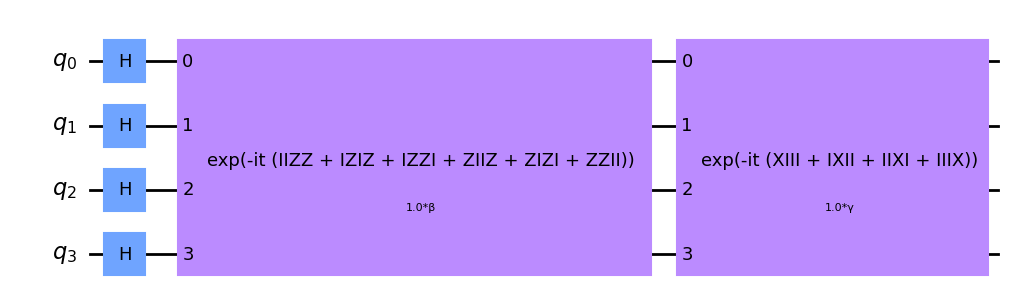

In [33]:
# Define the parameters
gamma = Parameter('γ')
beta = Parameter('β')
p=1
# Initialize the QAOA circuit with these parameters
qaoa = QAOA(optimizer=COBYLA(), reps=p, initial_point=[gamma, beta])
# Constructing the circuit with parameter objects
example_qc = qaoa.construct_circuit([gamma, beta], operator=qubitOp)[0]
# Drawing the circuit with parameter labels
example_qc.draw('mpl')

### Computing Objective Function Values
For each combination of the gamma and beta parameters, we construct the QAOA circuit and calculate the expectation value of the Hamiltonian \$\langle H \rangle\$. This step is crucial in evaluating the performance of our QAOA circuit for different parameter values, guiding us towards the optimal solution.


In [34]:
# Initial parameters
p = 1
qaoa = QAOA(optimizer=COBYLA(), reps=p)
gamma = np.linspace(-2*np.pi, 2*np.pi, 100)
beta = np.linspace(-2*np.pi, 2*np.pi, 100)

# Compute the objective function value for each parameter combination
obj_vals = np.zeros((len(gamma), len(beta)))
for i, gamma_val in enumerate(gamma):
    for j, beta_val in enumerate(beta):
        # Bind alpha and beta parameters to the operator
        qc = qaoa.construct_circuit([gamma_val, beta_val], operator=qubitOp)[0]
        # Evaluate Backend
        backend = Aer.get_backend('aer_simulator')
        statevector = Statevector.from_instruction(qc)
        # Use the Operator class to compute the expectation value of the Hamiltonian
        expectation =  statevector.expectation_value(qubitOp).real
        obj_vals[i,j] = expectation

### Plotting the Parameter Landscape
The heatmap below represents the landscape of the objective function across different values of \$\gamma\$ and \$\beta\$. The color intensity indicates the expectation value of the Hamiltonian, helping identify the regions where optimal parameters may lie.


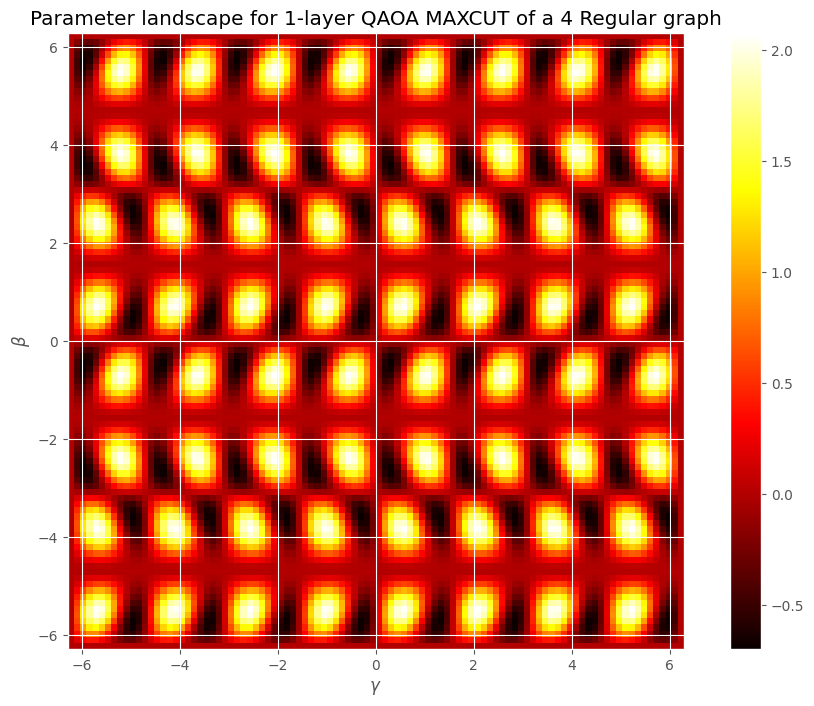

In [35]:
# Plot the parameter landscape as a heatmap
plt.imshow(obj_vals.T, origin='lower', cmap='hot', extent=(-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title('Parameter landscape for 1-layer QAOA MAXCUT of a 4 Regular graph')
plt.colorbar()
plt.show()

In [46]:
import plotly.graph_objs as go
# Create the Plotly figure
fig = go.Figure(data=[go.Surface(x=gamma, y=beta, z=obj_vals, colorscale='hot')])

# Set the layout and axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  width=700, height=700, margin=dict(l=65, r=50, b=65, t=90))

# Show the figure
fig.show()

### Brute Force Solution for the Max-Cut Problem
A brute-force solution to the Max-Cut problem involves evaluating every possible partition of the graph's nodes into two sets. We calculate the 'cut' for each partition, which is the number of edges between the two sets. The goal is to maximize this cut. This method is computationally intensive and not practical for large graphs, but it gives an exact solution for smaller ones.

In [37]:
from itertools import combinations

def compute_max_cut_brute_force(G):
    nodes = G.nodes()
    n = len(nodes)
    max_cut_value = 0
    max_cut_partition = None

    # Iterate over all possible ways to split the nodes into two sets
    for size in range(1, n // 2 + 1):
        for subset in combinations(nodes, size):
            cut_value = sum((G.has_edge(i, j) for i in subset for j in G.nodes() if j not in subset))
            if cut_value > max_cut_value:
                max_cut_value = cut_value
                max_cut_partition = subset

    return max_cut_partition, max_cut_value

# Apply the brute force solution to our graph
max_cut_partition, max_cut_value = compute_max_cut_brute_force(G)

### Visualizing the Brute Force Solution
The solution obtained from the brute force method is visualized on the graph. Nodes are colored based on the partition they belong to in the solution that maximizes the Max-Cut. This visualization gives a clear picture of the optimal partitioning of the graph.


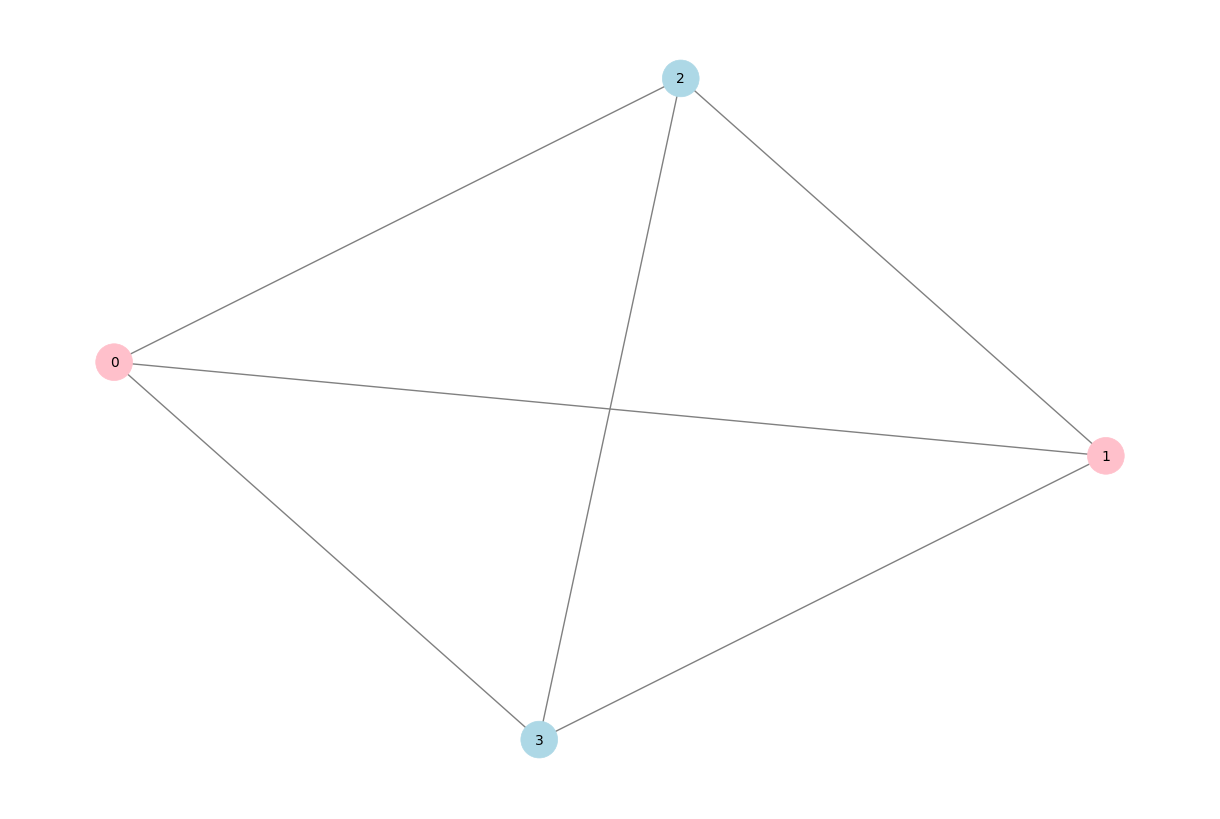

In [38]:
# Define the colors for each node based on the brute force solution partition
node_colors = ['pink' if node in max_cut_partition else 'lightblue' for node in G.nodes()]

# Draw the graph with nodes colored based on the solution
nx.draw(G, with_labels=True, node_color=node_colors, edge_color='gray', node_size=700, font_size=10)
plt.show()

## Quantum Variational Eigensolver (VQE) Simulation

This code snippet is designed to simulate a quantum instance using the Variational Quantum Eigensolver (VQE) approach with the Quantum Approximate Optimization Algorithm (QAOA). The VQE is a hybrid quantum-classical algorithm that finds the ground state of a Hamiltonian, an essential task in various quantum computing applications.

### Key Components

- **Simulation Parameters**: The number of iterations (`MAX_ITERATIONS`), restarts (`N_RESTARTS`), and QAOA layers (`N_LAYERS`) are set.
- **Optimizer**: The ADAM optimizer is used for parameter optimization in the quantum circuit.
- **Quantum Instance**: The `Aer` backend from Qiskit is used to simulate the quantum state.
- **Intermediate Result Storage**: A callback function `store_intermediate_result` is defined to track and print the optimization progress every 100 iterations, and to store the values of the cost function, along with the parameters (gamma and beta).

### Optimization Process

- The code runs the VQE for a specified number of restarts (`N_RESTARTS`), each with a randomly initialized state.
- In each restart, the QAOA algorithm is applied to find the minimum eigenvalue of the Hamiltonian (`qubitOp`), representing the problem instance.
- The `compute_minimum_eigenvalue` method of the QAOA instance is used to carry out the optimization.

### Visualization

- The results of the optimization, including the evaluation count and corresponding energy values, are plotted to visualize the energy convergence.
- This visualization helps in understanding how the optimizer's performance improves over iterations and how quickly it converges to a solution.

### Note

- The actual Hamiltonian (`qubitOp`) and other dependencies are assumed to be defined elsewhere in the notebook.



---------- Solving for Exact Ground State ----------

Minimum Energy is {   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': (-1+0j)}

---------- Simulating Instance on Quantum using VQE ----------

Testing Optimizer ADAM
Running Optimization at n_restart=0
ADAM iteration 100 	 cost function -0.088572820331484
ADAM iteration 200 	 cost function -0.1855365987362785
ADAM iteration 300 	 cost function -0.2818617804173082
ADAM iteration 400 	 cost function -0.37301739048276084
ADAM iteration 500 	 cost function -0.44895216700227003
ADAM iteration 600 	 cost function -0.5108957835567232
ADAM iteration 700 	 cost function -0.5608120829378229
ADAM iteration 800 	 cost function -0.5978099220087977
ADAM iteration 900 	 cost funct

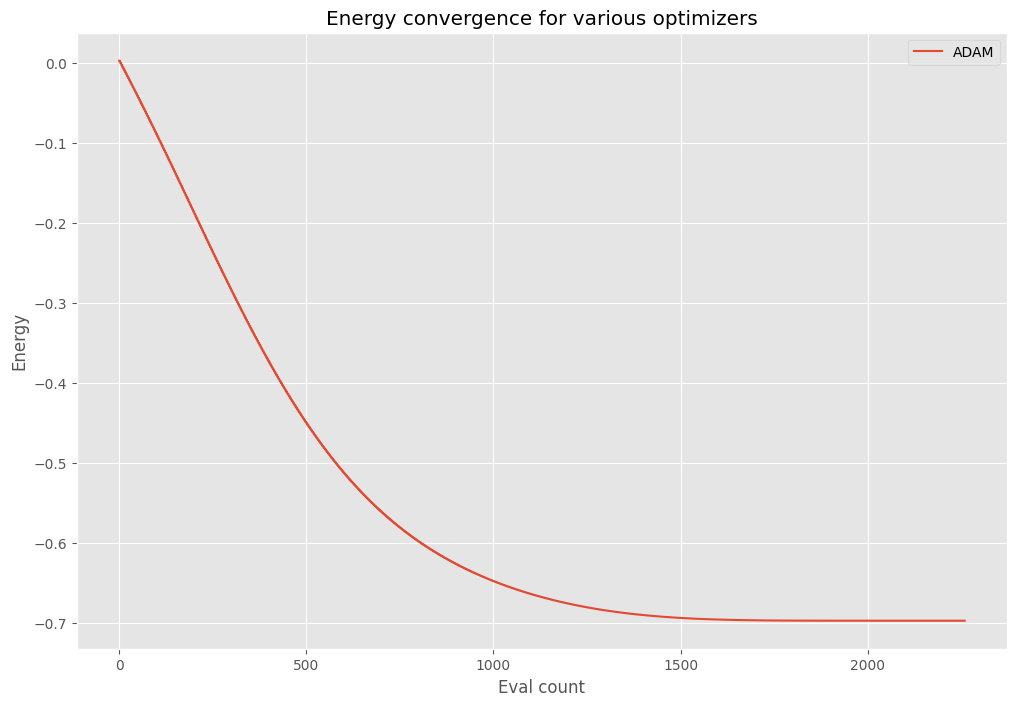

In [58]:
print(f"\n{'-'*10} Solving for Exact Ground State {'-'*10}\n")

exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=qubitOp)

print(f"Minimum Energy is {exact_result}")
print(f"\n{'-'*10} Simulating Instance on Quantum using VQE {'-'*10}\n")

MAX_ITERATIONS=1000
N_RESTARTS=1
N_LAYERS=1

# Run optimisation code
# optimizer = COBYLA(maxiter=MAX_ITERATIONS)
optimizer = ADAM()
num_qubits = qubitOp.num_qubits
optimizer_results = []

counts = []
values = []
gamma_values = []
beta_values = []

algo = []

result = {"algo": None, "result": None}

backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend)
print(f"Testing Optimizer {type(optimizer).__name__}")

def store_intermediate_result(eval_count, parameters, mean, std):
    if eval_count % 100 == 0:
        print(
            f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}"
        )
    counts.append(eval_count)
    # Store gamma and beta values
    gamma_values.append(parameters[0])
    beta_values.append(parameters[1])
    values.append(mean)
    
for restart in range(N_RESTARTS):
    print(f"Running Optimization at n_restart={restart}")
    init_state = np.random.rand(N_LAYERS*2) * 2 * np.pi
    
    # QAOA definition
    qaoa = QAOA(
        optimizer=optimizer, 
        reps=N_LAYERS, 
        initial_point=init_state, 
        callback=store_intermediate_result, 
        quantum_instance=quantum_instance
    )
    
    qaoa_result = qaoa.compute_minimum_eigenvalue(qubitOp)


# Convergence array
total_counts = np.arange(0, len(counts))
values = np.asarray(values)

print(f"\n{'-'*10} Optimization Complete {'-'*10}\n")

plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(total_counts, values, label=type(optimizer).__name__)
plt.xlabel("Eval count")
plt.ylabel("Energy")
plt.title("Energy convergence for various optimizers")
plt.legend(loc="upper right")

In [59]:
# QAOA Result Analysis for MaxCut Problem

# Extract the most likely solution from QAOA results
most_likely_solution = max_cut.sample_most_likely(qaoa_result.eigenstate)

# Calculate the energy gap
energy_gap = exact_result.eigenvalue.real - qaoa_result.eigenvalue.real

# Convert exact result eigenstate to matrix form and get QAOA state
exact_result_vector = exact_result.eigenstate.to_matrix()
qaoa_state_vector = qaoa_result.eigenstate

# Compute inner product between exact result and QAOA state
inner_product = np.dot(exact_result_vector.conj(), qaoa_state_vector)

# Calculate the probability of success (adjusting for MAXCUT symmetry)
success_probability = (np.abs(inner_product)**2) * 2

# Calculate the approximation ratio
approximation_ratio = qaoa_result.eigenvalue.real/exact_result.eigenvalue.real

# Output performance metrics
print(f"\n{'-'*10} MAXCUT Performance Metrics {'-'*10}\n")

print(f"Final energy <C>: {qaoa_result.eigenvalue.real}")
print(f"Energy gap: {energy_gap}")
print(f"Probability of being in the ground state P(C_max): {success_probability}")
print(f"Approximation Ratio: {approximation_ratio}")

# Output other additional information
print(f"\n{'-'*10} Other Performance Information {'-'*10}\n")

print(f"Optimization time: {qaoa_result.optimizer_time}")
print(f"Max-cut objective: {qaoa_result.eigenvalue.real + offset}")
print(f"QAOA most likely solution: {most_likely_solution}")
print(f"Actual solution: {max_cut.sample_most_likely(exact_result_vector)}")
print(f"Solution objective: {max_cut.to_quadratic_program().objective.evaluate(most_likely_solution)}")



---------- MAXCUT Performance Metrics ----------

Final energy <C>: -0.6975160992364
Energy gap: -0.3024839007636
Probability of being in the ground state P(C_max): 0.2463691999517652
Approximation Ratio: 0.6975160992364

---------- Other Performance Information ----------

Optimization time: 3.735755681991577
Max-cut objective: -3.6975160992364
QAOA most likely solution: [1. 0. 1. 0.]
Actual solution: [1. 1. 0. 0.]
Solution objective: 4.0


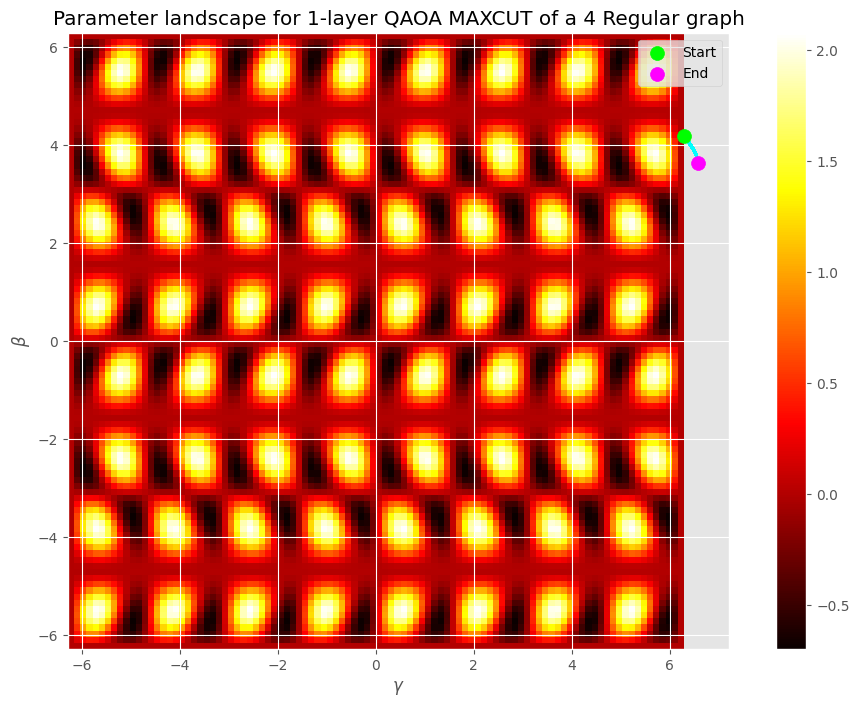

In [61]:
# Your existing code for plotting the heatmap
plt.imshow(obj_vals.T, origin='lower', cmap='hot', extent=(-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title('Parameter landscape for 1-layer QAOA MAXCUT of a 4 Regular graph')
plt.colorbar()

# Overlay the convergence path
plt.plot(gamma_values, beta_values, marker='o', color='cyan', markersize=1, linestyle='-', linewidth=1)


# Increase the size and change the color of the start and end markers
if gamma_values and beta_values:
    plt.scatter(gamma_values[0], beta_values[0], color='lime', s=100, label='Start', zorder=2)
    plt.scatter(gamma_values[-1], beta_values[-1], color='magenta', s=100, label='End', zorder=2)


plt.legend()
plt.show()

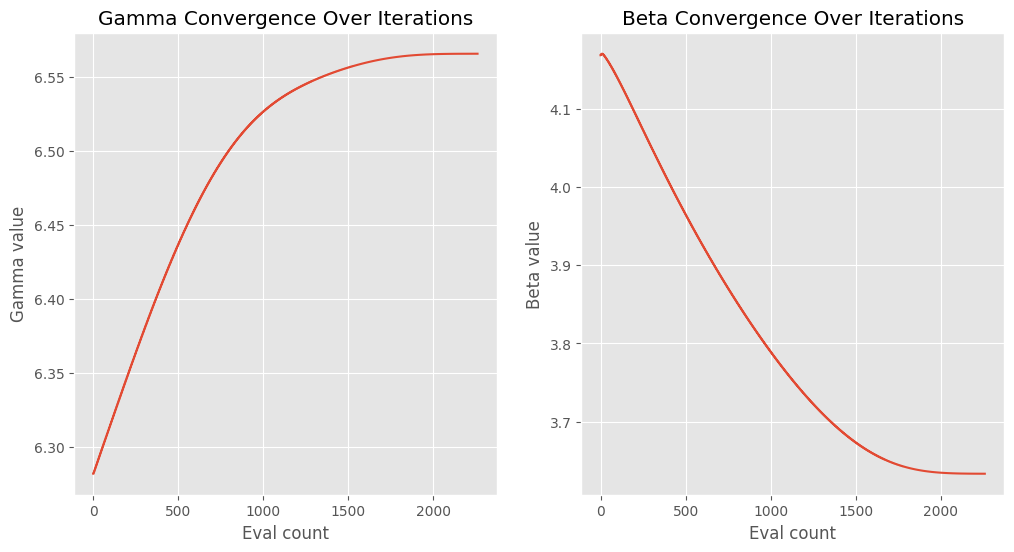

In [62]:
# Optionally, plot gamma and beta values over iterations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(total_counts, gamma_values, label='Gamma')
plt.xlabel('Eval count')
plt.ylabel('Gamma value')
plt.title('Gamma Convergence Over Iterations')

plt.subplot(1, 2, 2)
plt.plot(total_counts, beta_values, label='Beta')
plt.xlabel('Eval count')
plt.ylabel('Beta value')
plt.title('Beta Convergence Over Iterations')
plt.show()

In [45]:
import qiskit.tools.jupyter
%qiskit_version_table